### Interest Rate Models_Programming Project #1
#### Team Member: Weihao Li, Xinlu Xiao
#### Contact Information: WEIHAO.LI@baruchmail.cuny.edu, xinluxiao.baruch@gmail.com

#### README:
1. Problem1: in the "Curve" class: disc_factor(start_time, end_time) 
2. Problem2: in the "Curve" class: forward_rate(start_time, end_time)
3. Problem3: in the "swap" class: swap_rate(in_mrt, in_feq)
4. Problem4: please refer to the optimization part
5. Problem5: in the end: pv_swap(in_mrt,in_coupon,in_feq,libor,ois,start_time)

In [72]:
# Python imports

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep, splint
import scipy.integrate as integrate
import scipy.optimize as opt
import time
import pandas as pd
from datetime import datetime as dt

In [73]:
# data Parsing

def data_reader(in_type):
    ''' handy function to read given excel '''
    s_filename = 'DataSheetCurve.xls'
    s_sheetname = '3M LIBOR  OIS'
    if in_type == 'LIBOR':
        return pd.read_excel(s_filename, s_sheetname, skiprows=1,  parse_cols='B:E')[:2]
    elif in_type == 'ED Futures':
        return pd.read_excel(s_filename, s_sheetname, skiprows=5,  parse_cols='B:F')[:8]
    elif in_type == 'Swap Rates':
        return pd.read_excel(s_filename, s_sheetname, skiprows=15, parse_cols='B:E')[:11]
    elif in_type == 'Fed Funds':
        return pd.read_excel(s_filename, s_sheetname, skiprows=28, parse_cols='B:E')[:1]
    elif in_type == 'Basis Swap Rates':
        return pd.read_excel(s_filename, s_sheetname, skiprows=32, parse_cols='B:E')[:16]
    else:
        raise TypeError('There is no such instrument type')

In [74]:
# read eurodollar data
df = data_reader('ED Futures')
ed_rate = df['Rate']
ed_date = [0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75]

# read swap rates data
df = data_reader('Swap Rates')
swap_rate = df['Rate']
swap_date = [2.0,3.0,4.0,5.0,7.0,10.0,12.0,15.0,20.0,25.0,30.0]

# read basis swap rates data
df = data_reader('Basis Swap Rates')
basis_rate = df['Basis (bp)'] * 1e-4
basis_date = [0.25,0.5,0.75,1.0,1.5,2.0,3.0,4.0,5.0,7.0,10.0,12.0,15.0,20.0,25.0,30.0]

# read fed fund effective rates data
df = data_reader('Fed Funds')
OIS_rate = df['Rate'].copy()
OIS_date = [0.0]

# read libor rates data
df = data_reader('LIBOR')
LIBOR_rate = df['Rate'].copy()
LIBOR_date = [0.0,0.25]

In [75]:
# Curve class

class Curve():
    def __init__(self, in_k, in_fi):
        '''
        in_k: knot points
        in_fi: knot values
        '''
        self._k  = in_k
        self._fi = in_fi
        self.tck = splrep(self._k, self._fi) 
        
    # calculate the OIS and LIBOR instantaneous rate
    def instantaneous_rate(self, in_time):
        '''
        in_time: evaluated point
        '''
        return splev(in_time,self.tck)
    
    # calculate the derivitive of the curve
    def dev(self,in_time,d):
        '''
        in_time: evaluated point
        d: derivative degree
        '''
        return splev(in_time,self.tck,der = d)
                     
    # calculate the discount factor
    def disc_factor(self, start_time, end_time):
        return math.exp(-splint(start_time, end_time, self.tck))
                     
    # calculate the forward rate
    def forward_rate(self, start_time, end_time):
        return (math.exp(splint(start_time,end_time,self.tck))-1)/(end_time-start_time)

In [76]:
# Swap class

class Swap():
    def __init__(self, in_ois, in_libor, in_time):
        '''
        in_ois: ois curve object
        in_libor: libor curve object
        in_time: evaluated point
        '''
        self.ois = in_ois
        self.libor = in_libor
        self.time = in_time
     
    # calculate break-even swap rates
    def swap_rate(self, in_mrt, in_feq):
        '''
        in_mrt: maturity
        in_feq: payment frequency
        '''
        # fixed leg
        maturity = in_mrt
        fix_ = 0
        while maturity >0:
            fix_ += 0.5 * self.ois.disc_factor(self.time, maturity)
            maturity -= 1.0 / in_feq

        # floating leg
        maturity = in_mrt
        float_ = 0
        while maturity >0:
            float_+= 0.25 * self.libor.forward_rate(maturity-0.25,maturity)*self.ois.disc_factor(self.time,maturity)
            maturity -= .25 # quarterly in US
        
        return float_/fix_
    
    # calculate the break-even basis rates
    def basis_rate(self, in_mrt):
        '''
        in_mrt: maturity
        '''
        maturity = in_mrt
        # the leg paying libor
        libor_ = 0
        while maturity > 0:
            libor_ += 0.25 * (self.libor.forward_rate(maturity - 0.25, maturity)\
                            - self.ois.forward_rate(maturity - 0.25, maturity))\
                            *self.ois.disc_factor(self.time, maturity)
            maturity -= 0.25
        
        # the leg paying ois and spread
        maturity = in_mrt
        ois_ = 0
        while maturity > 0:
            ois_+= 0.25 *self.ois.disc_factor(self.time, maturity)
            maturity -= .25
       
        return libor_  / ois_  

In [93]:
# optimization:

def obj(O_L):
    '''
    O_L: a vector which represent the coefficient at each knots on both OIS and LIBOR
    '''
    
    # initialization 
    LIBOR_fi = O_L[0:18]
    OIS_fi = O_L[18:]
    
    ois1 = Curve(knots,OIS_fi)
    libor1 = Curve(knots,LIBOR_fi)
    swap1 = Swap(ois1,libor1,0)
    
    libor_spl = splrep(knots, LIBOR_fi)
    ois_spl = splrep(knots, OIS_fi)
    
    # optimization goal function
    goal = sum([(swap1.basis_rate(i) - k) ** 2 for i,k in zip(basis_date,basis_rate)])+\
           sum([(libor1.forward_rate(i,i + 0.25) - k) ** 2 for i,k in zip(ed_date,ed_rate)])+\
           sum([(swap1.swap_rate(i,2) - k) ** 2 for i,k in zip(swap_date,swap_rate)]) +\
            (splev(0,libor_spl) - 0.0055) ** 2 + (splev(0,ois_spl) - 0.0007) ** 2

    # penelty
    # default lambda = 0.05
    pnl  = 0.025*integrate.quad(lambda x:ois1.dev(x,2)**2 + libor1.dev(x,2)**2,0,30)[0]

    return goal + pnl

In [94]:
# optimization implement
# optimization time is based on your computer
# less than 2 minutes on 8 gb ram, i7 ubuntu 16.04

knots = [-15.0, -10.0, -5.0, 0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0]
O_L   = [0.01] * 36

# Set the tolerance as 1e-6
ans = opt.fmin_bfgs(obj,O_L,epsilon = 1e-6,gtol = 1e-6)

D:\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 92
         Function evaluations: 3686
         Gradient evaluations: 97


[ 0.00948221  0.01414217 -0.00916129  0.00544859  0.00697146  0.00788897
  0.01306847  0.02447046  0.03070799  0.03350761  0.03243098  0.02976297
  0.02966949  0.02928756  0.02442422  0.00629273  0.01080152  0.00989981]
[ 0.00957092  0.01343255 -0.0058782   0.00088913  0.00132623  0.00342057
  0.00838131  0.02080887  0.02873632  0.03220095  0.03086699  0.02893241
  0.02836591  0.02841898  0.02334743  0.00656951  0.01074168  0.00990729]


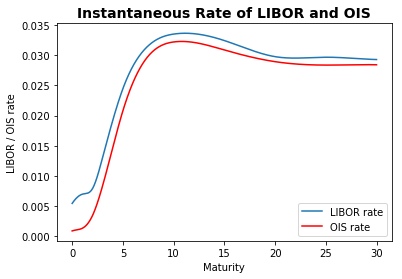

In [105]:
# draw the libor curve and ois curve
libor_value = ans[0:18]
ois_value = ans[18:]
print(libor_value)
print(ois_value)

tck = splrep(knots,libor_value)
tck_2 = splrep(knots,ois_value)

spl_libor_date = np.arange(0,30,0.01)
spl_libor_rate = splev(spl_libor_date, tck)
spl_ois_date = np.arange(0,30,0.01)
spl_ois_rate = splev(spl_ois_date,tck_2)

plt.plot(spl_libor_date, spl_libor_rate, label = 'LIBOR rate')
plt.plot(spl_ois_date, spl_ois_rate, 'r', label = 'OIS rate')
plt.legend()
plt.ylabel('LIBOR / OIS rate')
plt.xlabel('Maturity')
plt.title('Instantaneous Rate of LIBOR and OIS', fontsize = 14, fontweight = 'bold')
plt.show()

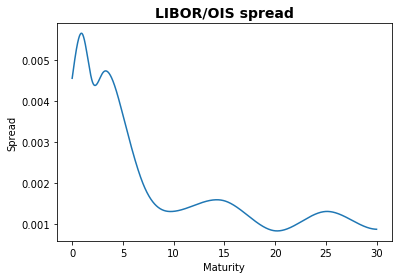

In [106]:
# draw the spread curve
plt.plot(spl_ois_date,spl_libor_rate - spl_ois_rate)
plt.ylabel('Spread')
plt.xlabel('Maturity')
plt.title('LIBOR/OIS spread', fontsize = 14, fontweight = 'bold')
plt.show()

In [97]:
# calculate the present value of swap
def pv_swap(in_notional,in_mrt,in_coupon,in_feq,libor,ois,start_time):
    '''
    in_notional: notional
    in_mrt: maturity
    in_coupon: coupon rate
    in_feq: payment frequency
    libor: curve object
    ois: curve object
    start_time: forward or spot
    '''
    # fixed leg
    maturity = in_mrt
    fixed_ = 0.0
    while maturity > 0:
        fixed_ += 0.5 * in_coupon * ois.disc_factor(start_time, maturity)
        maturity -= 1/in_feq
        
    
    # floating leg
    maturity = in_mrt
    float_ = 0.0
    while maturity > 0:
        float_+= 0.25 * libor.forward_rate(maturity-0.25,maturity)*ois.disc_factor(start_time,maturity)
        maturity -= .25 
    
    return (fixed_ - float_)*in_notional      

In [98]:
# set up parameter to test the valuation function of swap
knots_test = [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0, 25.0, 31.0, 32.0, 33.0, 34.0, 35.0]
ois_test = Curve(knots_test, ois_value)
libor_test = Curve(knots_test, libor_value)

In [112]:
# spot swap test
notional = 100.0
maturity_test = 2.25
coupon_rate = 0.05
frequency = 2.0
spot = 0

result = pv_swap(notional, maturity_test,coupon_rate,frequency, libor_test,ois_test,spot)
print('### Present Value of Swap ###')
print('Notional:', notional)
print('Maturity:', maturity_test)
print('Coupon Rate:', coupon_rate)
print('Payment Frequency:', int(frequency))
print('->PV:', result)

### Present Value of Swap ###
Notional: 100.0
Maturity: 2.25
Coupon Rate: 0.05
Payment Frequency: 2
->PV: 10.817210369686713
